# Assignment 3: Word2Vec

In this assignment, we will see how we can use Word2Vec (or any similar word embedding) to use information from unlabelled data to help us classify better!

You will be using the sentiment data from last week, either the yelps or movies, whichever you wish. 

Your goal will be to simulate the following situation: you have a **small** set of labelled data and a large set of unlabelled data. Show how the two follow 2 techniques compare as the amount of labelled data increases. You should train them on the small labelled subset and test their performance on the rest of the data. 

In other words, train on 1k, test on 99k. Then train on 2k, test on 98k. Then train on 4k, test on 96k. Etc.

1. Logistic regression trained on labelled data, documents represented as term-frequency matrix of your choice. You can learn the vocabulary from the entire dataset or only the labelled data.

2. Logistic regression trained on the labelled data, documents represented as word2vec vectors where you train word2vec using the entire dataset. Play around with different settings of word2vec (training window size, K-negative, skip-gram vs BOW, training windows, etc.). Note: we didn't go over the options in detail in class, so you will need to read about them a bit!

You can read about the gensime word2vec implementation [here](https://radimrehurek.com/gensim/models/word2vec.html).

In [4]:
#!pip install gensim

In [3]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from gensim import utils
import matplotlib.ticker as mtick
import pickle
from sklearn.model_selection import train_test_split

from re import sub
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")
plt.style.use('bmh')
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
def train_test_split(data, train_share, seed=None):
    data = data.copy().sample(frac=1, random_state=seed).reset_index(drop=True)
    train_size = round(data.shape[0]*(train_share))
    df_train = data[0:train_size]
    df_test = data[train_size:]
    return df_train, df_test

In [6]:
def preprocess(docs,  w2v=None, stopwords=None, model=None, train_vectorizer=False, vectorizer=None):  
    if w2v:
        # vectorize documents with pre-trained w2v model
        tokenized_docs = [utils.simple_preprocess(doc) for doc in docs]
        tokenized_docs = [[w for w in t if w not in stopwords] 
                        for t in tokenized_docs]
        
        vectorized_w_docs = [[model.wv.__getitem__(w) for w in doc] for doc in tokenized_docs]
        vectorized_docs = np.empty((0, 100))
        for doc in vectorized_w_docs:
            new_doc = np.sum(doc, axis=0)/np.linalg.norm(np.sum(doc, axis=0))
            vectorized_docs = np.append(vectorized_docs, [new_doc], axis=0)

        return vectorized_docs
    
    if train_vectorizer:
        # train the vectorizer model
        vectorizer = TfidfVectorizer(min_df=.03,
                                     max_df=.97,
                                     vocabulary=None,
                                     stop_words='english',
                                     norm=False)
        
        vectorizer = vectorizer.fit(docs)
        V = vectorizer.transform(docs)
        V = np.asarray(V.todense())
        return V, vectorizer
    
    # vectorize documents with vectorizer model
    V = vectorizer.transform(docs)
    V = np.asarray(V.todense())
    return V

In [7]:
def get_train_test_sets(df_train, df_test, w2v=False, stopwords=None, model=None): 
    # process V
    if w2v:
        V_train = preprocess(df_train.text, w2v=w2v, stopwords=stopwords,  model=model)
        V_test = preprocess(df_test.text, w2v=w2v, stopwords=stopwords,  model=model)
        
    else:
        V_train, vectorizer = preprocess(df_train.text, train_vectorizer=True)
        V_test = preprocess(df_test.text, train_vectorizer=False, vectorizer=vectorizer)
     
    # process y
    y_train = df_train.positive
    y_test = df_test.positive
    return V_train, y_train, V_test, y_test

In [8]:
def predict_acc(V_train, y_train, V_test, y_test):
    # fit the model on train set and predict sentiment using the test documents
    LR = LogisticRegression().fit(V_train, y_train)
    y_hat = LR.predict(V_test)

    # record accuracy
    acc = accuracy_score(y_test, y_hat)
    return acc

### Training the w2v model

In [23]:
# load data
yelps = pd.read_csv('yelps.csv',header=0)#.sample(frac=0.01, random_state=2).reset_index(drop=True)
yelps = yelps[(yelps.text!='..') &(yelps.text!='...')&(yelps.text!=':(')].reset_index(drop=True)

In [24]:
# tokenize documents
tokenized_docs = [utils.simple_preprocess(doc) for doc in yelps.text]
tokenized_docs = [[w for w in t if w not in stop_words] 
                        for t in tokenized_docs]

In [25]:
# train model 
model = Word2Vec(sentences=tokenized_docs, size=100, min_count=1, sg=1, window=7)

In [11]:
# pickle the model
filename = 'w2v.sav'
pickle.dump(model, open(filename, 'wb'))

### Predicting sentiment with increasing train set size

In [12]:
# load the model 
w2v_model = pickle.load(open(filename, 'rb'))

In [23]:
train_shares = [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19]

In [25]:
# compute accuracies of models at predicting sentiment with different train size
scores = {'vectorizer':[], 'word2vec':[]}

for share in train_shares:
    df_train, df_test = train_test_split(yelps, train_share=share, seed=None)
    
    #vectorizer
    V_train, y_train, V_test, y_test = get_train_test_sets(df_train, df_test)
    acc = predict_acc(V_train, y_train, V_test, y_test)
    scores['vectorizer'].append(acc)
    
    # word2vec
    V_train_w2v, y_train, V_test_w2v, y_test = get_train_test_sets(df_train, df_test, w2v=True, stopwords=stop_words, model=w2v_model)
    acc = predict_acc(V_train_w2v, y_train, V_test_w2v, y_test)
    scores['word2vec'].append(acc)

In [26]:
results = pd.concat([pd.Series(train_shares, name='train_share'),pd.DataFrame.from_dict(scores)], axis=1)
results

,train_share,vectorizer,word2vec
0,0.01,0.857655,0.919625
1,0.03,0.882226,0.936793
2,0.05,0.893494,0.940515
3,0.07,0.895063,0.941279
4,0.09,0.900241,0.944450
5,0.11,0.901122,0.945359
6,0.13,0.902654,0.947137
7,0.15,0.902999,0.946799
8,0.17,0.905601,0.947783
9,0.19,0.905641,0.948481


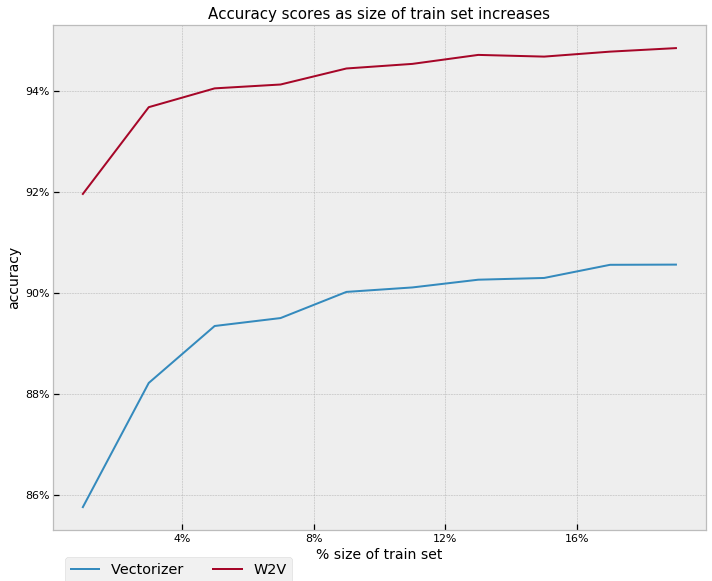

In [27]:
fig, ax = plt.subplots(figsize = (10,8))
ax.set_title('Accuracy scores as size of train set increases', fontsize=15)
labels = ['Vectorizer','W2V']

ax.plot(results['train_share'],results['vectorizer'])
ax.plot(results['train_share'],results['word2vec'])
ax.set_ylabel('accuracy', fontsize=14)
ax.set_xlabel('% size of train set', fontsize=14)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))

plt.tight_layout()
fig.legend(labels, loc='lower left', fontsize='x-large', ncol=3, bbox_to_anchor=(0.08, -0.015, 0.8, 1))
plt.show()

Here I compared accuracies of the two models for different sizes of the train set (which I anyway kept small as per instructions). We can basically see two things:
+ Performance of both models increases with the size of the train set, even if at a decreasing rate
+ W2V outperforms the vectorizer for any train set size

### Exploring hyperparameters

Below, I am exploring the setting of the window size hyperparameter by comparing accuracies for different W2V models. I have changed my code set-up slightly to speed up the computations.

In [71]:
scores = {'window size 3':[],'window size 5':[],'window size 7':[],'window size 8':[]}
windows = [3,5,7,8]
train_shares = [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19]
n_reps = list(range(10))
y = yelps.positive

for wind in windows:
    print('Window', wind,':')
    model = Word2Vec(sentences=tokenized_docs, size=100, min_count=1, sg=1, window=wind)
    print('Model trained')
    
    vectorized_docs =  np.zeros((len(tokenized_docs),100))
    for i,doc in enumerate(tokenized_docs):
        for w in doc:
            try:
                vectorized_docs[i,:] += model.wv[w]
            except:
                None 
    vectorized_docs = (vectorized_docs.T/np.linalg.norm(vectorized_docs,axis=1)).T
    print('Docs vectorized')
    
    for share in train_shares:
        acc_list = []
        for i in n_reps:
            V_train, V_test, y_train, y_test = train_test_split(vectorized_docs, y, train_size=share, random_state=None)
            LR = LogisticRegression().fit(V_train, y_train)
            y_hat = LR.predict(V_test)
            acc_list.append(accuracy_score(y_test, y_hat))
        scores[f'window size {wind}'].append(np.mean(acc_list))
    print('Scores computed')

Window 3 :
Model trained
Docs vectorized
Scores computed
Window 5 :
Model trained
Docs vectorized
Scores computed
Window 7 :
Model trained
Scores computed
Window 8 :
Model trained
Docs vectorized
Scores computed


In [72]:
results_hyper = pd.concat([pd.Series(train_shares, name='train_share'),pd.DataFrame.from_dict(scores)], axis=1)
results_hyper

,train_share,window size 3,window size 5,window size 7,window size 8
0,0.01,0.911794,0.916143,0.919002,0.918512
1,0.03,0.928500,0.932179,0.935207,0.935173
2,0.05,0.934608,0.938246,0.940311,0.942046
3,0.07,0.938253,0.942123,0.943683,0.943937
4,0.09,0.940624,0.944009,0.945285,0.945682
5,0.11,0.942293,0.945173,0.946635,0.946072
6,0.13,0.941923,0.945938,0.947272,0.947801
7,0.15,0.944738,0.946805,0.947487,0.948525
8,0.17,0.945523,0.946725,0.949246,0.949165
9,0.19,0.945335,0.947590,0.949235,0.949884


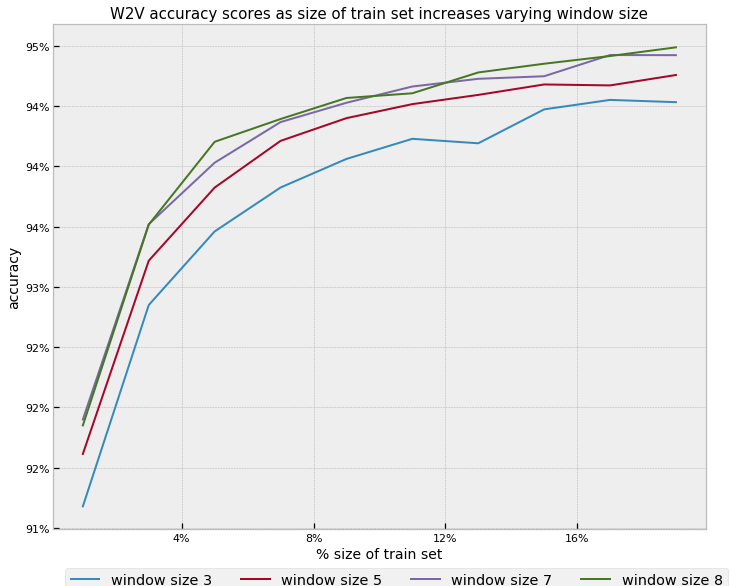

In [73]:
fig, ax = plt.subplots(figsize = (10,8))
ax.set_title('W2V accuracy scores as size of train set increases varying window size', fontsize=15)
labels = list(scores.keys())

for w in labels:
    ax.plot(results_hyper['train_share'],results_hyper[f'{w}'])
ax.set_ylabel('accuracy', fontsize=14)
ax.set_xlabel('% size of train set', fontsize=14)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))

plt.tight_layout()
fig.legend(labels, loc='lower left', fontsize='x-large', ncol=4, bbox_to_anchor=(0.08, -0.025, 0.8, 1))
plt.show()

As we can see, it seems there is an important gain in accuracy when increasing the window size up to 7, while there is no much difference between a window size of 7 or of 8. With additional time, it would have been also interesting to try tuning other hyperparameters e.g. the training algorithm or the size of the embedding space.